# Population decoding
Attempt at decoding behavioral data from population level neural activity.

In [7]:
import pandas as pd
from pathlib import Path
import sys
import statsmodels.api as sm
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
from fcutils.plot.figure import clean_axes
from sklearn.model_selection import KFold
from myterial import teal_dark, teal, indigo_dark, blue_darker, pink, salmon_dark
from scipy.stats import pearsonr
import numpy as np

colors = dict(
    s=teal_dark,
    apex_distance=teal_dark,
    curv_10cm=teal,
    curv_15cm=teal,
    curv_20cm=teal,
    curv_30cm=teal,
    v=salmon_dark, 
    v_squared=salmon_dark, 
    dv_250ms=pink,
    dv_500ms=pink,
    dv_1000ms=pink,
    omega=blue_darker,
    omega_squared=blue_darker,
    domega_250ms=indigo_dark,
    domega_500ms=indigo_dark,
    domega_1000ms=indigo_dark,
)


sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from analysis.ephys.utils import get_recording_names

glm_cache = Path(
    r"D:\GLM\data"
)
population_cache = Path(
    r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\population\data"
)

models_cache = Path(
    r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\population\linreg_models"
)

parquet_files = list(
    population_cache.glob("*.parquet")
)


# Get recordings filepaths

In [8]:
TARGET = "MOs"
recordings = get_recording_names(region=TARGET)
data = [
    pd.read_hdf(glm_cache / f"{rec}_bouts.h5") for rec in recordings
]

## Load data

In [9]:
def load_parquet_data(parquet_path):
    df = pd.read_parquet(population_cache / parquet_path)


    # remove rows with nans
    df = df.dropna(axis=0)
    df.reset_index(inplace=True, drop=True)

    # get units_ids
    units = [c for c in df.columns[18:] if "shuffle" not in c]

    X = add_constant(df[units])
    X_shuffle = {
        i: add_constant(df[[f"{unit}_shuffle_{i}" for unit in units]]) for i in range(100)
    }


    return df, units, X, X_shuffle


# Linear regression

Using 5x kfold cross validation, fit OLS linear prediction to various behavioral variables from neural activity.
Fit models for real neural data and for each shuffles of real data.
Then look for which variables we can do better than the shuffles.

In [10]:
variables = ["s", "v", "apex_distance",  "dv_500ms", "omega", "domega_500ms", "curv_15cm"]
nospatial = ["v",  "dv_500ms", "omega", "domega_500ms"]
nospeed = ["s", "apex_distance", "omega", "domega_500ms", "curv_15cm"]
noomega = ["s", "v", "apex_distance",  "dv_500ms", "curv_15cm"]


behav_vars = dict(
    s = nospatial,
    curv_15cm = nospatial,
    apex_distance = nospatial,
    v = nospeed,
    dv_500ms = nospeed,
    omega = noomega,
    domega_500ms = noomega,
)


In [11]:
def fit_model(df:pd.DataFrame, X:pd.DataFrame, X_shuffle:dict, variable:str, savename:str):
    Y = df[variable]

    # split into 5x kfold
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)

    pearson_correlations = {f"{variable}_shuffle_{i}":[] for i in range(100)}
    pearson_correlations[variable] = []

    # loop over folds
    for i, (train_index, test_index) in enumerate(kf.split(df)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # fit OLS & getc correlation on test
        model = sm.OLS(Y_train, X_train).fit()

        # TODO get a different accuracy metric ?
        # model.save(str(models_cache / f"{savename}_{variable}_fold_{i}.pkl"))
        pearson_correlations[variable].append(
            pearsonr(model.predict(X_test), Y_test)[0]
        )


        # fit for each shuffle
        for s in range(100):
            X_train_shuffle = X_shuffle[s].iloc[train_index]
            X_test_shuffle = X_shuffle[s].iloc[test_index]

            # fit shuffled and get correlation
            model_shuffle = sm.OLS(Y_train, X_train_shuffle).fit()
            # model_shuffle.save(str(models_cache / f"{savename}_{variable}_shuffle_{s}_fold_{i}.pkl"))
            pearson_correlations[f"{variable}_shuffle_{i}"].append(
                pearsonr(model_shuffle.predict(X_test_shuffle), Y_test)[0]
            )


    return pearson_correlations


In [12]:

correlations = {f"{variable}_shuffle_{i}":[] for i in range(100) for variable in variables}
for variable in variables:
    correlations[variable] = []
correlations["recording"] = []


for i, pqf in enumerate(parquet_files):
    if "220409" in pqf.stem:
        continue

    print(f"Doing recording {1+i}/{len(parquet_files)}")
    df, units, X, X_shuffle = load_parquet_data(pqf)
    correlations["recording"].append(pqf.stem)

    for variable in variables:
        print(f"    doing variable '{variable}'")
        varcors = fit_model(df, X, X_shuffle,  variable, pqf.stem)

        for i in range(100):
            correlations[f"{variable}_shuffle_{i}"].append(
                np.mean(varcors[f"{variable}_shuffle_{i}"])
            )
        correlations[variable].append(np.mean(varcors[variable]))



Doing recording 1/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 2/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 3/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 4/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 5/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 6/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 7/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 8/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 9/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 10/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 11/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 12/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'
Doing recording 13/13
    doing variable 's'


c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Federico\.conda\envs\glm\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    doing variable 'v'
    doing variable 'apex_distance'
    doing variable 'dv_500ms'
    doing variable 'omega'
    doing variable 'domega_500ms'
    doing variable 'curv_15cm'


In [13]:
# Save avg correlation of each model
pd.DataFrame(correlations).to_hdf(
    str(population_cache.parent / "linmods_correlations.h5"), key="hdf",
)

# Analysis

Get for each variables which models performed better than canche.

In [14]:
correlations = pd.DataFrame(correlations)
cols = [c for c in correlations.columns if "shuffle" not in c and "recording" not in c]
cols

['s', 'v', 'apex_distance', 'dv_500ms', 'omega', 'domega_500ms', 'curv_15cm']

In [15]:
import matplotlib
import matplotlib.patheffects as path_effects
from matplotlib.artist import Artist

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


def outline(artist: Artist, lw: float = 1, color: str = "white"):
    artist.set_path_effects(
        [path_effects.withStroke(linewidth=lw, foreground=color,)]
    )


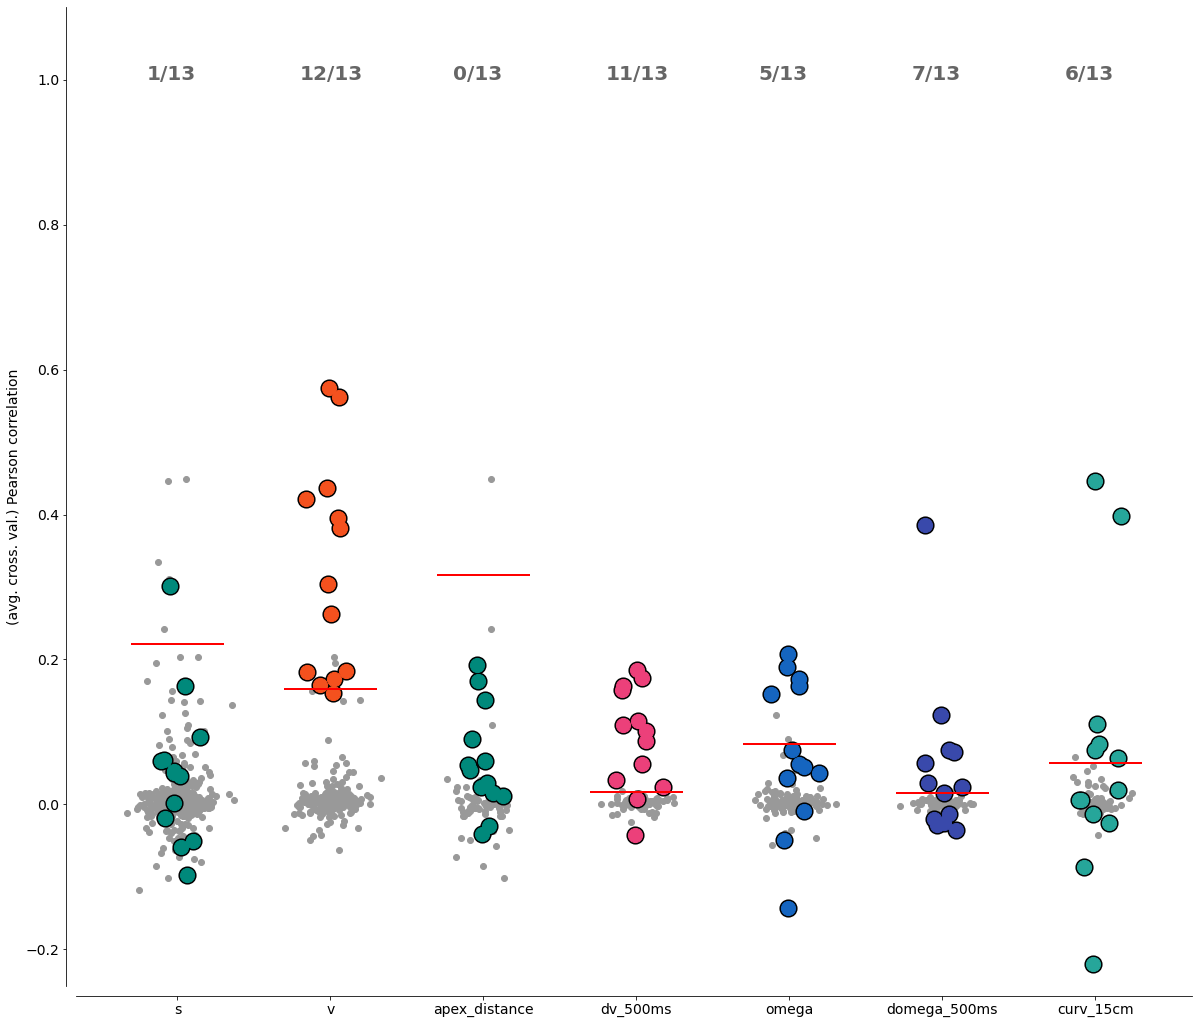

In [21]:
recs = [f.stem for f in parquet_files]


ONE = np.ones(len(correlations))

f, ax = plt.subplots(figsize=(20, 18))

for n, var in enumerate(cols):
    y = correlations[var]
    x = ONE*n + np.random.normal(0, .07, len(correlations))
    ax.scatter(x, y, color="k", s=200, lw=4, ec="k", zorder=100, label=var)
    ax.scatter(x, y, color=colors[var], s=200, zorder=100, label=var)


    # plot suffled correlations
    shuffle_cols = [c for c in correlations.columns if "shuffle" in c and var in c]
    y_shuff = correlations[shuffle_cols].values.ravel()

    x = np.ones(len(y_shuff)) * n + np.random.normal(0, .1, len(y_shuff))
    ax.scatter(x, y_shuff, color=[.6, .6, .6], alpha=1, zorder=-1)


    # get the threshld as 99th percentile
    th = np.nanpercentile(y_shuff, 99)
    ax.plot([n-.3, n+.3], [th, th], color="r", lw=2, zorder=100)

    # count how many in y are above the threshold
    count = np.sum(y > th)

    # add text to display count
    ax.text(n-.2, 1, f"{count}/{len(y)}", color=[.4, .4, .4], fontsize=20, fontweight="bold")

clean_axes(f)
_ = ax.set(ylim=[-.25, 1.1],  xticks=np.arange(len(cols)), xticklabels=cols, ylabel="(avg. cross. val.) Pearson correlation")


### plot predictions for a recording

In [17]:
# plot histogram of average MSE for each shuffle


def plot_results(rec_data, units_data, models_correlations, fitted_models, t0=2000):
    f, axes = plt.subplots(ncols=2, nrows=len(variables), figsize=(20, 18), gridspec_kw={"width_ratios": [.33, 1]}, sharex=False)

    for i, var in enumerate(variables):
        # plot pearsonr distributions
        avg_shuff_pearsonr = [models_correlations[f"{var}_shuffle_{i}"][0] for i in range(100)]

        low, high = np.percentile(avg_shuff_pearsonr, [.5, 99.5])
        axes[i, 0].plot([low, high], [-1, -1], color="k", linewidth=2)
        axes[i, 0].scatter([np.median(avg_shuff_pearsonr)], [-1], color="white",fc="white", zorder=100, ec="k", linewidth=1, s=25)

        axes[i, 0].hist(avg_shuff_pearsonr, color=[.5, .5, .5])
        axes[i, 0].axvline(models_correlations[var][0], color=colors[var], lw=4)
        
        axes[i, 0].set(title=var, xlim=[-.25, 1])
        axes[i, 0].axvline(0, lw=2, color="k", zorder=100)

        # plot predictions of real and shuffled models
        T = np.linspace(0, int(600 * 5 / 1000), 600)
        axes[i, 1].fill_between(T, rec_data[var][t0:t0+600], 0, color="k", alpha=.25, label="data")
        axes[i, 1].plot(T, fitted_models[f"{var}_fold_1"].predict(units_data[t0:t0+600]), color=colors[var], lw=4, label="prediction")


    axes[0, 0].set(ylabel="count", xticks=[])
    axes[1, 0].set(ylabel="count", xticks=[])
    axes[2, 0].set(ylabel="count", xticks=[])
    axes[3, 0].set(ylabel="count", xticks=[])
    axes[4, 0].set(ylabel="count", xticks=[])
    axes[5, 0].set(ylabel="count", xlabel="Parson r")

    axes[0, 1].set(ylabel="s (cm)", xticks=[])
    axes[1, 1].set(ylabel="speed (cm/s)", xticks=[])
    axes[2, 1].set(ylabel="delta speed (cm/s)", xticks=[])
    axes[3, 1].set(ylabel="ang. vel. (deg/s)", xticks=[])
    axes[4, 1].set(ylabel="delta ang. vel. (deg/s)", xticks=[])
    axes[5, 1].set(ylabel="curvature @15cm", xlabel="time (s)")

    clean_axes(f)
    f.tight_layout()


# plot_results(X, RESULTS, MODELS, t0=2000)

In [18]:
rec = recs[4]

rec_models = {f.stem.replace(rec, "")[1:]: sm.load(f) for f in models_cache.glob(f"{rec}*.pkl")}
rec_correlations = correlations.loc[correlations.recording == rec].to_dict()
df, units, X, X_shuffle = load_parquet_data(rec+".parquet")

KeyError: 0

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


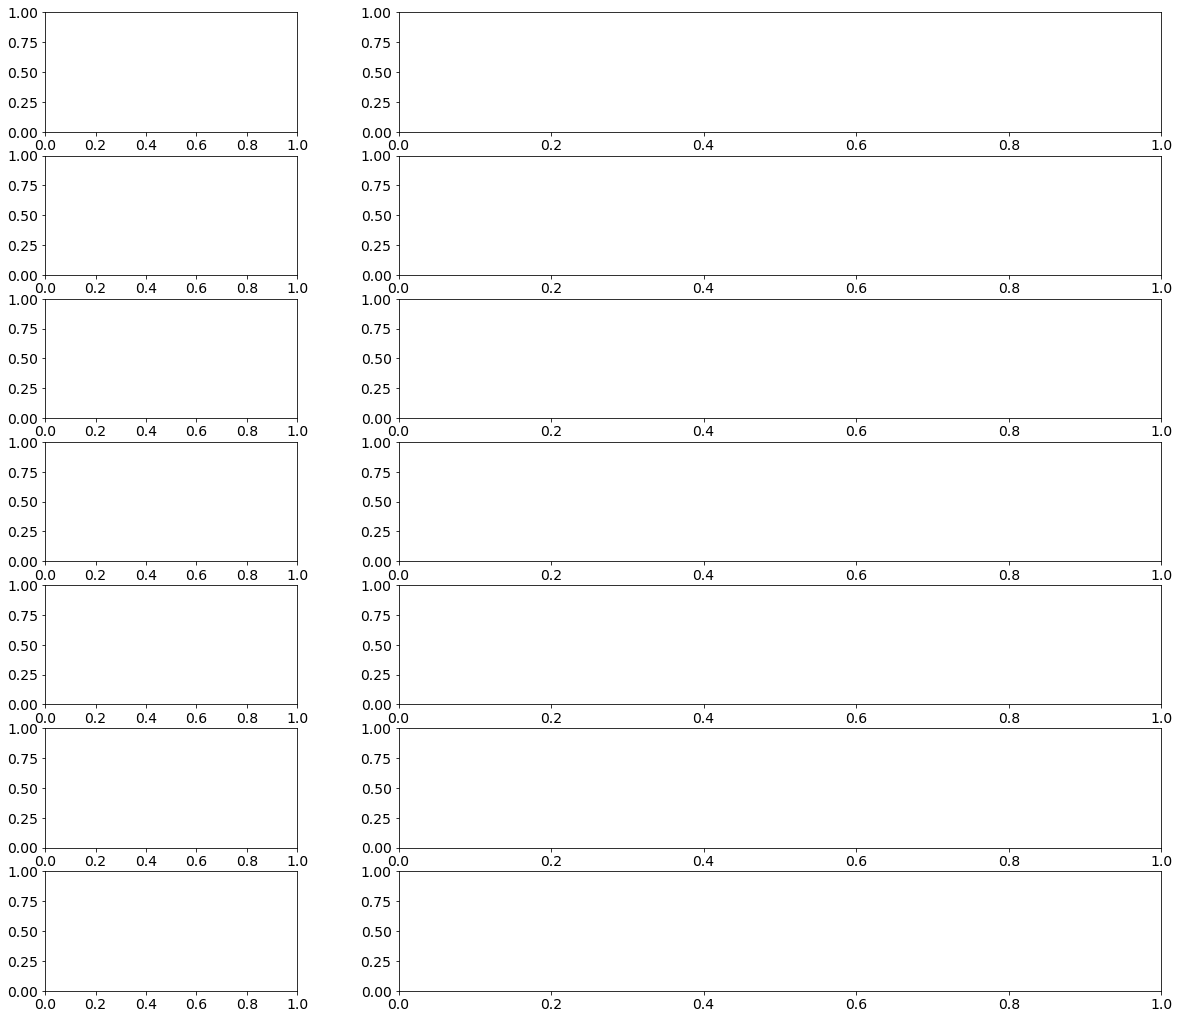

In [19]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


plot_results(df, X, rec_correlations, rec_models, t0=2000)